# M4 Competition Dataset - Financial Time Series Forecasting
This notebook is made for finance master thesis which explores how different models perform on M4 competition dataset. Results can be used to guide financial analysts and institutions in selecting forecasting models that are better suited for short-term vs long-term planning.

In [3]:
from datasetsforecast.m4 import M4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from data_loading import load_m4_financial
import random
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler
from models import (
    ARIMAModel,
    HoltWintersModel,
    RNNModel,
    LSTMModel,
    XGBoostModel,
    InformerModel,
    TFTModel
)

In [4]:
#Testing that torch uses gpu
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

CUDA available: False
Device name: No GPU found


## 1. M4 Dataset importing
To load M4 Dataset i will use 'datasetforecast' library

In [5]:
#Uncomment if data is not yet downloaded
#load_m4_financial(data_dir='./data')

In [6]:
df_info = pd.read_csv("data/m4/datasets/M4-info.csv")
df_train_daily = pd.read_csv("data/m4/datasets/Daily-train.csv")

In [7]:
df_info_finance = df_info[df_info['category'] == 'Finance']
df_info_finance

M4id category  Frequency  Horizon      SP    StartingDate
15245  Y15246  Finance          1        6  Yearly  01-01-81 12:00
15246  Y15247  Finance          1        6  Yearly  01-01-83 12:00
15247  Y15248  Finance          1        6  Yearly  01-01-94 12:00
15248  Y15249  Finance          1        6  Yearly  01-01-94 12:00
15249  Y15250  Finance          1        6  Yearly  01-01-93 12:00
...       ...      ...        ...      ...     ...             ...
98948   D3590  Finance          1       14   Daily  30-03-01 12:00
98949   D3591  Finance          1       14   Daily  30-03-01 12:00
98950   D3592  Finance          1       14   Daily  30-03-01 12:00
98951   D3593  Finance          1       14   Daily  30-03-01 12:00
98952   D3594  Finance          1       14   Daily  30-03-01 12:00

[24534 rows x 6 columns]

In [8]:
df_train_daily_finance = df_train_daily[df_train_daily['V1'].isin(df_info_finance['M4id'])]
df_train_daily_finance = df_train_daily_finance.merge(
    df_info_finance[['M4id', 'StartingDate']],
    left_on='V1',
    right_on='M4id',
    how='left'
)
df_train_daily_finance.drop(columns='M4id', inplace=True)


In [9]:
df_train_daily_finance

V1            V2            V3            V4            V5  \
0     D2036   2785.000000   2780.300000   2780.300000   2780.300000   
1     D2037   1398.590000   1373.010000   1359.540000   1337.160000   
2     D2038   3560.000000   3530.000000   3520.000000   3510.000000   
3     D2039   1821.000000   1806.000000   1792.000000   1778.000000   
4     D2040   4066.542677   4085.371744   3987.976769   3968.892827   
...     ...           ...           ...           ...           ...   
1554  D3590   1244.090000   1217.990000   1130.060000   1165.450000   
1555  D3591  11729.200000  11451.400000  10490.400000  10851.400000   
1556  D3592  14823.100000  14481.400000  13306.200000  13720.900000   
1557  D3593   1699.210000   1658.900000   1507.610000   1548.830000   
1558  D3594    481.970000    478.430000    471.340000    474.410000   

                V6           V7            V8           V9           V10  ...  \
0      2780.100000   2785.00000   2777.200000   2778.30000   2782.170000  ...   
1      1366.730000   1356.70000   1353.430000   1377.93000   1382.230000  ...   
2      3500.000000   3490.00000   3460.000000   3450.00000   3440.000000  ...   
3      1764.000000   1750.00000   1736.000000   1820.00000   1806.000000  ...   
4      4012.677163   4054.60221   3987.194679   3997.11777   3963.263482  ...   
...            ...          ...           ...          ...           ...  ...   
1554   1240.800000   1214.45000   1215.320000   1286.24000   1332.760000  ...   
1555  11637.100000  11269.70000  11247.700000  12061.60000  12464.500000  ...   
1556  14662.400000  14232.20000  14174.700000  15134.10000  15632.000000  ...   
1557   1656.830000   1608.42000   1622.460000   1732.39000   1796.950000  ...   
1558    479.180000    482.41000    484.250000    484.14000    486.590000  ...   

      V9912  V9913  V9914  V9915  V9916  V9917  V9918  V9919  V9920  \
0       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...   
1554    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1555    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1556    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1557    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1558    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

        StartingDate  
0     01-04-05 12:00  
1     04-01-99 12:00  
2     16-05-03 12:00  
3     19-04-00 12:00  
4     21-05-13 12:00  
...              ...  
1554  30-03-01 12:00  
1555  30-03-01 12:00  
1556  30-03-01 12:00  
1557  30-03-01 12:00  
1558  30-03-01 12:00  

[1559 rows x 9921 columns]

In [10]:
def clean_series(group):
    first_valid = group['Observation'].first_valid_index()
    last_valid = group['Observation'].last_valid_index()
    if first_valid is None or last_valid is None:
        return pd.DataFrame(columns=group.columns)  # all NaNs, return empty
    cleaned = group.loc[first_valid:last_valid].copy()
    cleaned['Observation'] = cleaned['Observation'].ffill()
    return cleaned.dropna(subset=['Observation'])

In [11]:
def df_preprocessing(df):
    df_long = pd.melt(
        df,
        id_vars=['V1', 'StartingDate'],
        var_name='DayIndex',
        value_name='Observation'
    )
    df_long['DayOffset'] = (
        df_long['DayIndex']
        .str.replace('V', '', regex=False)
        .astype(int)
    )
    df_long['Date'] = pd.to_datetime(df_long['StartingDate']) + pd.to_timedelta(df_long['DayOffset'] - 1, unit='D')
    df_long.drop(['DayIndex', 'DayOffset'], axis=1, inplace=True)
    df_long.sort_values(by=['V1', 'Date'], inplace=True)
    df_cleaned = df_long.groupby('V1', group_keys=False).apply(clean_series).reset_index(drop=True)
    time_series_dict = {}
    for series_id, sub_df in df_cleaned.groupby('V1'):
        sub_df = sub_df.set_index('Date').sort_index()
        ts = sub_df['Observation']
        time_series_dict[series_id] = ts
    return time_series_dict

In [12]:
dict_finance_train_daily = df_preprocessing(df_train_daily_finance)

/var/folders/dp/g_9xlnhn1219h1vk_shtj1wm0000gn/T/ipykernel_81694/3264734010.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_long['Date'] = pd.to_datetime(df_long['StartingDate']) + pd.to_timedelta(df_long['DayOffset'] - 1, unit='D')
/var/folders/dp/g_9xlnhn1219h1vk_shtj1wm0000gn/T/ipykernel_81694/3264734010.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_long.groupby('V1', group_keys=False).apply(clean_series).reset_index(drop=True)


Time series included: 1559
Average time series length: 3250 days
Average return: 0.001
Average volatility: 0.021
Maximum return: 31.32672366745497
Minimum return: -0.9685954868584624
Skeweness: 395.7193173274963
Kurtosis: 405225.0491300916


time_series  volatility  mean_return          start_date  \
0       D2036    0.009371     0.000294 2005-01-05 12:00:00   
1       D2037    0.007999     0.000041 1999-04-02 12:00:00   
2       D2038    0.019211    -0.000441 2003-05-17 12:00:00   
3       D2039    0.018953     0.000112 2000-04-20 12:00:00   
4       D2040    0.010622     0.000423 2013-05-22 12:00:00   

             end_date  max_return  min_return  
0 2013-03-18 12:00:00    0.143316   -0.141166  
1 2009-09-28 12:00:00    0.067165   -0.078164  
2 2005-11-23 12:00:00    0.103030   -0.019139  
3 2000-09-02 12:00:00    0.083333   -0.008567  
4 2015-12-31 12:00:00    0.037144   -0.080368

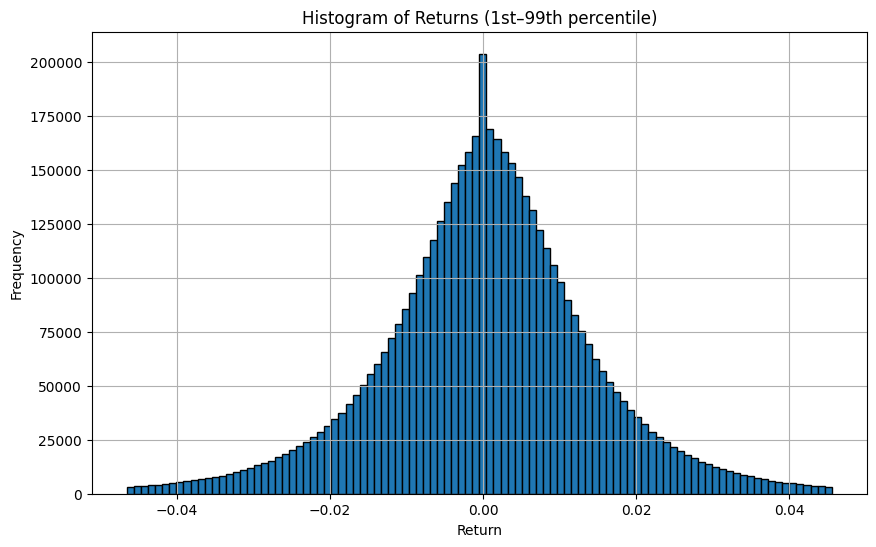

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

length = 0
volatility = 0
ts_returns = 0
ts_count = len(dict_finance_train_daily)
max_return = 0
min_return = 0
all_returns = []
df_stats = pd.DataFrame(columns=["time_series", "volatility", "mean_return", "start_date", "end_date", "max_return", "min_return"])

for x in dict_finance_train_daily:
    ts = dict_finance_train_daily[x]
    length += len(ts)
    returns = ts.pct_change().dropna()
    ts_returns += returns.mean()
    volatility += returns.std()
    all_returns.extend(returns.tolist())
    df_stats.loc[len(df_stats)] = {"time_series": x, "volatility": returns.std(), "mean_return": returns.mean(), "start_date": ts.index.min(), "end_date": ts.index.max(), "max_return": returns.max(), "min_return": returns.min()}
    
    if max_return < returns.max():
        max_return = returns.max()
    if min_return > returns.min():
        min_return = returns.min()

skewness = skew(all_returns)
kurt = kurtosis(all_returns)

print(f"Time series included: {len(dict_finance_train_daily)}")
print(f"Average time series length: {round(length / ts_count)} days")
print(f"Average return: {round(ts_returns / ts_count, 3)}")
print(f"Average volatility: {round(volatility / ts_count, 3)}")
print(f"Maximum return: {max_return}")
print(f"Minimum return: {min_return}")
print(f"Skeweness: {skewness}")
print(f"Kurtosis: {kurt}")

display(df_stats.head())

returns_array = np.array(all_returns)
low, high = np.percentile(returns_array, [1, 99])
filtered_returns = returns_array[(returns_array >= low) & (returns_array <= high)]

plt.figure(figsize=(10, 6))
plt.hist(filtered_returns, bins=100, edgecolor='black')
plt.title("Histogram of Returns (1st–99th percentile)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [14]:
def display_random_series(data_dict, count=5):
    for x in range(count):
        key = random.choice(list(data_dict.keys()))
        series = data_dict[key]
        returns = series.pct_change().dropna()
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        axs[0].plot(series)
        axs[0].set_title(f"Time Series: {key}")
        axs[0].set_xlabel("Time")
        axs[0].set_ylabel("Value")

        axs[1].hist(returns, bins='auto', edgecolor='black')
        axs[1].set_title("Histogram of Returns")
        axs[1].set_xlabel("Return")
        axs[1].set_ylabel("Frequency")

        plt.tight_layout()
        plt.show()

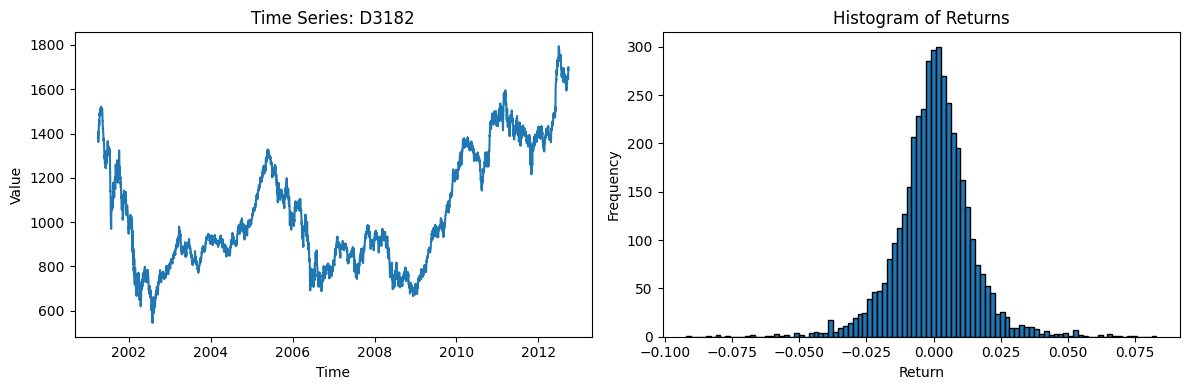

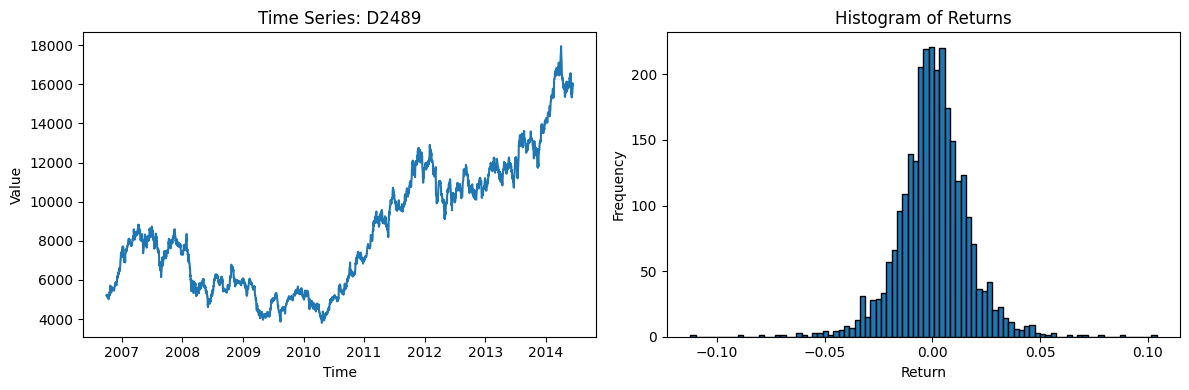

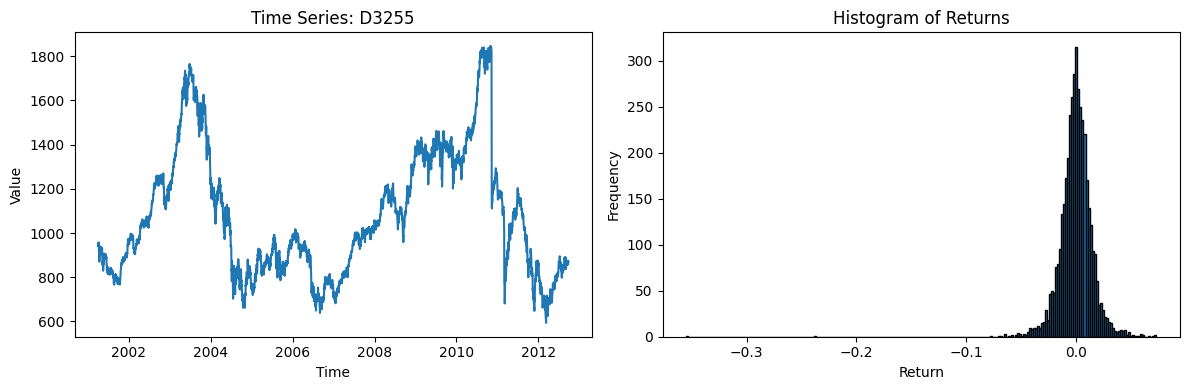

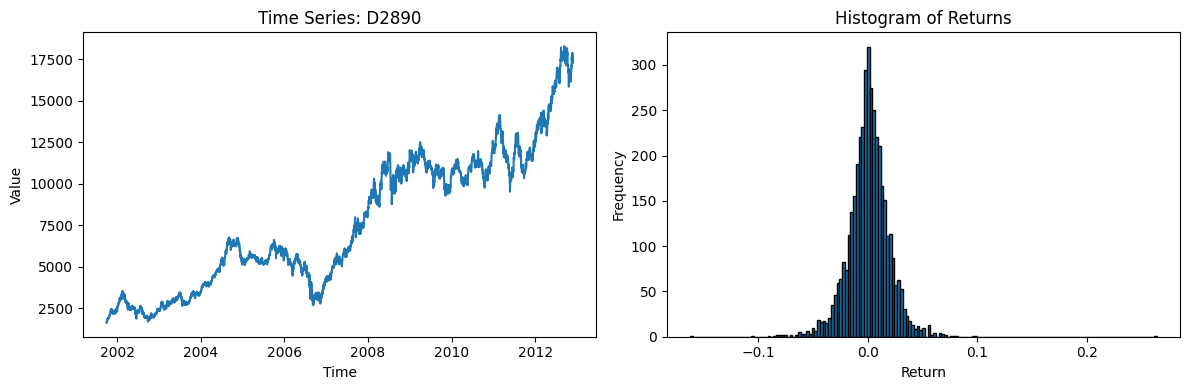

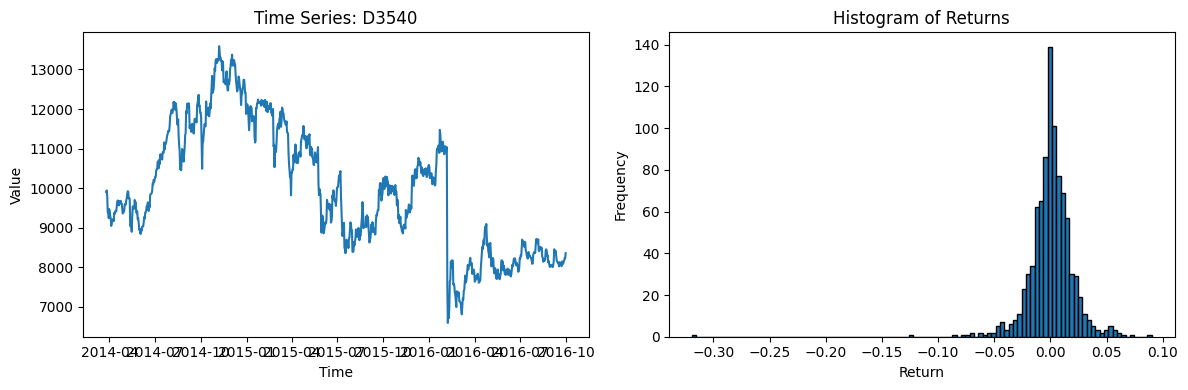

In [15]:
display_random_series(dict_finance_train_daily)

In [16]:
fitted_models = {}

for ts_name, train_series in dict_finance_train_daily.items():
    arima_model = ARIMAModel(
        start_p=1, 
        start_q=1,
        max_p=5,
        max_q=5,
        seasonal=False,
        m=1,             
        trace=False 
    )
    
    arima_model.fit(train_series)

    fitted_models[ts_name] = arima_model

forecasts = {}
for ts_name, model in fitted_models.items():
    forecast_values = model.forecast(steps=14)
    forecasts[ts_name] = forecast_values


/Users/SanteriPentinen/Gradu model/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/SanteriPentinen/Gradu model/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/SanteriPentinen/Gradu model/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/SanteriPentinen/Gradu model/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/SanteriPentinen/Gradu model/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: F

In [ ]:

fitted_holt_winters_models = {}

for ts_name, train_series in dict_finance_train_daily.items():
    hw_model = HoltWintersModel(
        seasonal='mul',
        seasonal_periods=5,
        trend='add'
    )
    
    hw_model.fit(train_series)
    
    fitted_holt_winters_models[ts_name] = hw_model

holt_winters_forecasts = {}
for ts_name, model in fitted_holt_winters_models.items():
    forecast_values = model.forecast(steps=14)  
    holt_winters_forecasts[ts_name] = forecast_values

In [23]:
def create_sequences(data, window_size=30):
    """
    Convert a 1D array 'data' into a supervised dataset of windows and next-step targets.

    :param data: 1D array of time series values
    :param window_size: number of time steps in each input sequence
    :return: (X, y) 
      X.shape => (num_samples, window_size)
      y.shape => (num_samples,)
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [24]:
window_size = 30

X_train_list = []
y_train_list = []

for series_id, ts_values in dict_finance_train_daily.items():
    # Create supervised windows
    X, y = create_sequences(ts_values, window_size=window_size)
    X_train_list.append(X)
    y_train_list.append(y)

# Concatenate into one big array
X_train_all = np.concatenate(X_train_list, axis=0)  # shape => (total_samples, window_size)
y_train_all = np.concatenate(y_train_list, axis=0)  # shape => (total_samples,)

# Reshape for RNN: (samples, timesteps, features)
# For univariate data, features = 1
X_train_all = X_train_all.reshape((X_train_all.shape[0], window_size, 1))

print("X_train_all shape:", X_train_all.shape)
print("y_train_all shape:", y_train_all.shape)



/var/folders/dp/g_9xlnhn1219h1vk_shtj1wm0000gn/T/ipykernel_81694/942682042.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i + window_size])


X_train_all shape: (5019457, 30, 1)
y_train_all shape: (5019457,)


In [ ]:
split_idx = int(len(X_train_all) * 0.9)
X_train_final = X_train_all[:split_idx]
y_train_final = y_train_all[:split_idx]
X_val_final = X_train_all[split_idx:]
y_val_final = y_train_all[split_idx:]

In [ ]:
scaler = MinMaxScaler()

# Fit on training input
train_shape = X_train_final.shape
X_train_2d = X_train_final.reshape(-1, 1)  # flatten
scaler.fit(X_train_2d)

# Transform both train and val
X_train_2d_scaled = scaler.transform(X_train_2d)
X_train_final = X_train_2d_scaled.reshape(train_shape)

val_shape = X_val_final.shape
X_val_2d = X_val_final.reshape(-1, 1)
X_val_2d_scaled = scaler.transform(X_val_2d)
X_val_final = X_val_2d_scaled.reshape(val_shape)

# Optionally, scale y as well if the output scale is large
y_train_final = y_train_final.reshape(-1, 1)
y_val_final = y_val_final.reshape(-1, 1)
scaler_y = MinMaxScaler()
scaler_y.fit(y_train_final)
y_train_final = scaler_y.transform(y_train_final)
y_val_final = scaler_y.transform(y_val_final)

print("Data scaling complete!")



In [ ]:

rnn_model = RNNModel(
    input_shape=(window_size, 1),  
    hidden_dim=50,           
    output_dim=1          
)

rnn_model.summary()

history = rnn_model.fit(
    X_train_final,
    y_train_final,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_final, y_val_final)
)

In [ ]:
lstm_model = LSTMModel(
    input_shape=(window_size, 1),
    hidden_dim=50,
    output_dim=1
)

lstm_model.summary()

history = lstm_model.fit(
    X_train_final,
    y_train_final,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_final, y_val_final)
)

In [ ]:
xgboost_model = XGBoostModel(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

xgboost_model.summary()

xgboost_model.fit(
    X_train_final,
    y_train_final,
    eval_set=[(X_val_final, y_val_final)],
    early_stopping_rounds=10
)

In [ ]:
def evaluate_informer(train, test, args):
    """Evaluate Informer model"""
    # Prepare dataset
    dataset = M4Dataset(args.series_id, train, seq_len=args.seq_len, 
                        label_len=args.label_len, pred_len=args.pred_len)
    
    # Model initialization
    model = Informer(
        enc_in=1, 
        dec_in=1,
        c_out=1,
        seq_len=args.seq_len,
        label_len=args.label_len,
        pred_len=args.pred_len,
        factor=args.factor,
        d_model=args.d_model,
        n_heads=args.n_heads,
        e_layers=args.e_layers,
        d_layers=args.d_layers,
        d_ff=args.d_ff,
        dropout=args.dropout,
        attn='prob',
        embed='timeF',
        freq=args.freq,
        activation='gelu',
        output_attention=args.output_attention,
        distil=args.distil,
        mix=args.mix
    )
    
    # Training
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    
    # Create dataloader
    train_data = torch.utils.data.DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True
    )
    
    # Train model
    model.train()
    for epoch in range(args.epochs):
        epoch_loss = 0
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_data):
            optimizer.zero_grad()
            outputs = model(batch_x, batch_x_mark, batch_y[:, :args.label_len, :], batch_y_mark[:, :args.label_len, :])
            loss = criterion(outputs, batch_y[:, -args.pred_len:, :])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_data):.6f}')
    
    # Evaluation
    model.eval()
    # Prepare input for prediction
    x_input = train[-args.seq_len:]
    x_input = torch.FloatTensor(x_input).unsqueeze(0).unsqueeze(-1)  # [batch, seq_len, feat_dim]
    x_mark = dataset.date_features[-args.seq_len-args.pred_len:-args.pred_len]
    x_mark = torch.FloatTensor(x_mark).unsqueeze(0)  # [batch, seq_len, feat_dim]
    
    # For decoder input, use zeros or last values
    dec_inp = torch.zeros((1, args.pred_len, 1)).float()
    dec_mark = torch.FloatTensor(dataset.date_features[-args.pred_len:]).unsqueeze(0)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(x_input, x_mark, dec_inp, dec_mark)
        predictions = outputs.squeeze().numpy()
    
    # Inverse transform
    predictions = dataset.inverse_transform(predictions)
    
    rmse = sqrt(mean_squared_error(test[:args.pred_len], predictions[:len(test)]))
    mae = mean_absolute_error(test[:args.pred_len], predictions[:len(test)])
    
    return {'rmse': rmse, 'mae': mae, 'predictions': predictions}
